In [13]:
import numpy as np
def lu_row(A):

    n = A.shape[0]   
    # 初始化矩阵
    U = np.copy(A).astype(float)  # 上三角矩阵
    L = np.eye(n)                 # 下三角矩阵
    P = np.eye(n)                 # 置换矩阵 

    for k in range(n-1):
        pivot = abs(U[k:, k]).argmax() + k
        

        if pivot != k:
            U[[k, pivot], k:] = U[[pivot, k], k:]
            if k > 0:
                L[[k, pivot], :k] = L[[pivot, k], :k]
            P[[k, pivot], :] = P[[pivot, k], :]
        
        # 对当前列下方的元素进行消元
        for i in range(k+1, n):
            factor = U[i, k] / U[k, k]
            L[i, k] = factor
            U[i, k:] = U[i, k:] - factor * U[k, k:]
    
    return P, L, U



np.random.seed(42)
n = 4
A = np.random.rand(n, n)
#A = np.array([[2, 3, 4], [1, 2, 3], [4, 5, 6]], dtype=float)
P, L, U = lu_row(A)
print("原始矩阵 A:")
print(A)
print("\n置换矩阵 P:")
print(P)
print("\n下三角矩阵 L:")
print(L)
print("\n上三角矩阵 U:")
print(U)

# 验证分解结果
print("\n验证 PA = LU:")
print("PA:")
print(P @ A)
print("LU:")
print(L @ U)
print("\n分解误差:")
print(np.max(np.abs(P @ A - L @ U)))


原始矩阵 A:
[[0.37454012 0.95071431 0.73199394 0.59865848]
 [0.15601864 0.15599452 0.05808361 0.86617615]
 [0.60111501 0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497 0.18340451]]

置换矩阵 P:
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]

下三角矩阵 L:
[[1.         0.         0.         0.        ]
 [0.44992904 1.         0.         0.        ]
 [0.72210983 0.64868509 1.         0.        ]
 [0.18742269 0.13587524 0.12082855 1.        ]]

上三角矩阵 U:
[[ 0.83244264  0.21233911  0.18182497  0.18340451]
 [ 0.          0.85517677  0.65018561  0.51613947]
 [ 0.          0.         -0.53247881  0.50265968]
 [ 0.          0.          0.          0.70093576]]

验证 PA = LU:
PA:
[[0.83244264 0.21233911 0.18182497 0.18340451]
 [0.37454012 0.95071431 0.73199394 0.59865848]
 [0.60111501 0.70807258 0.02058449 0.96990985]
 [0.15601864 0.15599452 0.05808361 0.86617615]]
LU:
[[0.83244264 0.21233911 0.18182497 0.18340451]
 [0.37454012 0.95071431 0.73199394 0.59865848]
 [0.60111501 0.

In [14]:
def chase_solver(a, b, c, d):

    n = len(b)
    # 临时存储变量
    cp = np.zeros(n-1)
    dp = np.zeros(n)
    
    # 前向消元
    dp[0] = d[0] / b[0]
    for i in range(1, n):
        temp = b[i] - a[i-1] * c[i-1] / b[i-1]
        dp[i] = (d[i] - a[i-1] * dp[i-1]) / temp
        cp[i-1] = c[i-1] / b[i-1]
    
    # 回代
    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in range(n-2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i+1]
    
    return x

# 测试追赶法
a = np.array([-1,-1,-1])  # 下对角线元素
b = np.array([2,3,3,2])  # 主对角线元素
c = np.array([-1,-1,-1])  # 上对角线元素
d = np.array([5,-12,11,-1])  # 结果向量

x = chase_solver(a, b, c, d)
print("解向量x:", x)

解向量x: [ 1.10666667 -2.78666667  3.04        1.02      ]


In [15]:
def lu_column(A):

    n = A.shape[0]
    L = np.eye(n, dtype=A.dtype)
    U = A.copy()
    P = np.eye(n)  # 添加置换矩阵来跟踪行交换
    
    for i in range(n):
        # 找到当前列中绝对值最大的行
        max_row_index = np.argmax(np.abs(U[i:, i])) + i
        
        # 交换当前行和最大值所在行
        if max_row_index != i:
            U[[i, max_row_index], :] = U[[max_row_index, i], :]
            L[[i, max_row_index], :i] = L[[max_row_index, i], :i]
            P[[i, max_row_index], :] = P[[max_row_index, i], :]

        # LU 分解
        for k in range(i + 1, n):
            if abs(U[i, i]) < 1e-10:
                raise ValueError("矩阵可能奇异")
            factor = U[k, i] / U[i, i]
            L[k, i] = factor
            U[k, i:] -= factor * U[i, i:]

    return P, L, U

def gauss_solver(A, b):

    n = A.shape[0]
    P, L, U = lu_column(A)
    
    # 对b进行相应的置换
    pb = P @ b
    
    # 前向替换求解 Ly = Pb
    y = np.zeros(n)
    for i in range(n):
        y[i] = pb[i] - np.dot(L[i, :i], y[:i])
    
    # 后向替换求解 Ux = y
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        if abs(U[i, i]) < 1e-10:
            raise ValueError("矩阵奇异，无法求解")
        x[i] = (y[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]

    return x

#解答题目
A = np.array([[1, 1, 0, 3], [2, 1, -1, 1], [3, -1, -1, 3], [-1, 2, 3, -1]], dtype=float)
b = np.array([4, 1, -3, 4], dtype=float)
x = gauss_solver(A, b)
print("解向量 x:", x)
print("验证 Ax =", A @ x)
print("原始 b =", b)
print("相对误差:", np.linalg.norm(A @ x - b) / np.linalg.norm(b))

解向量 x: [-1.33333333  2.33333333 -0.33333333  1.        ]
验证 Ax = [ 4.  1. -3.  4.]
原始 b = [ 4.  1. -3.  4.]
相对误差: 1.8450773572072177e-16


In [16]:
def cholesky(A):

    n = A.shape[0]
    

    L = np.zeros_like(A, dtype=float)
    

    for i in range(n):
        for j in range(i+1):
            if i == j:

                sum_sq = sum(L[i,k] ** 2 for k in range(j))
                if A[i,i] - sum_sq <= 0:
                    raise ValueError("矩阵不是正定的")
                L[i,i] = np.sqrt(A[i,i] - sum_sq)
            else:

                sum_prod = sum(L[i,k] * L[j,k] for k in range(j))
                L[i,j] = (A[i,j] - sum_prod) / L[j,j]
    
    return L

def cholesky_solver(A, b):

    L = cholesky(A)
    
 # 使用前代法求解Ly = b
    n = L.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = (b[i] - np.dot(L[i,:i], y[:i])) / L[i,i]
    
    # 使用回代法求解L^T x = y
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        x[i] = (y[i] - np.dot(L[i+1:,i], x[i+1:])) / L[i,i]
    
    return x

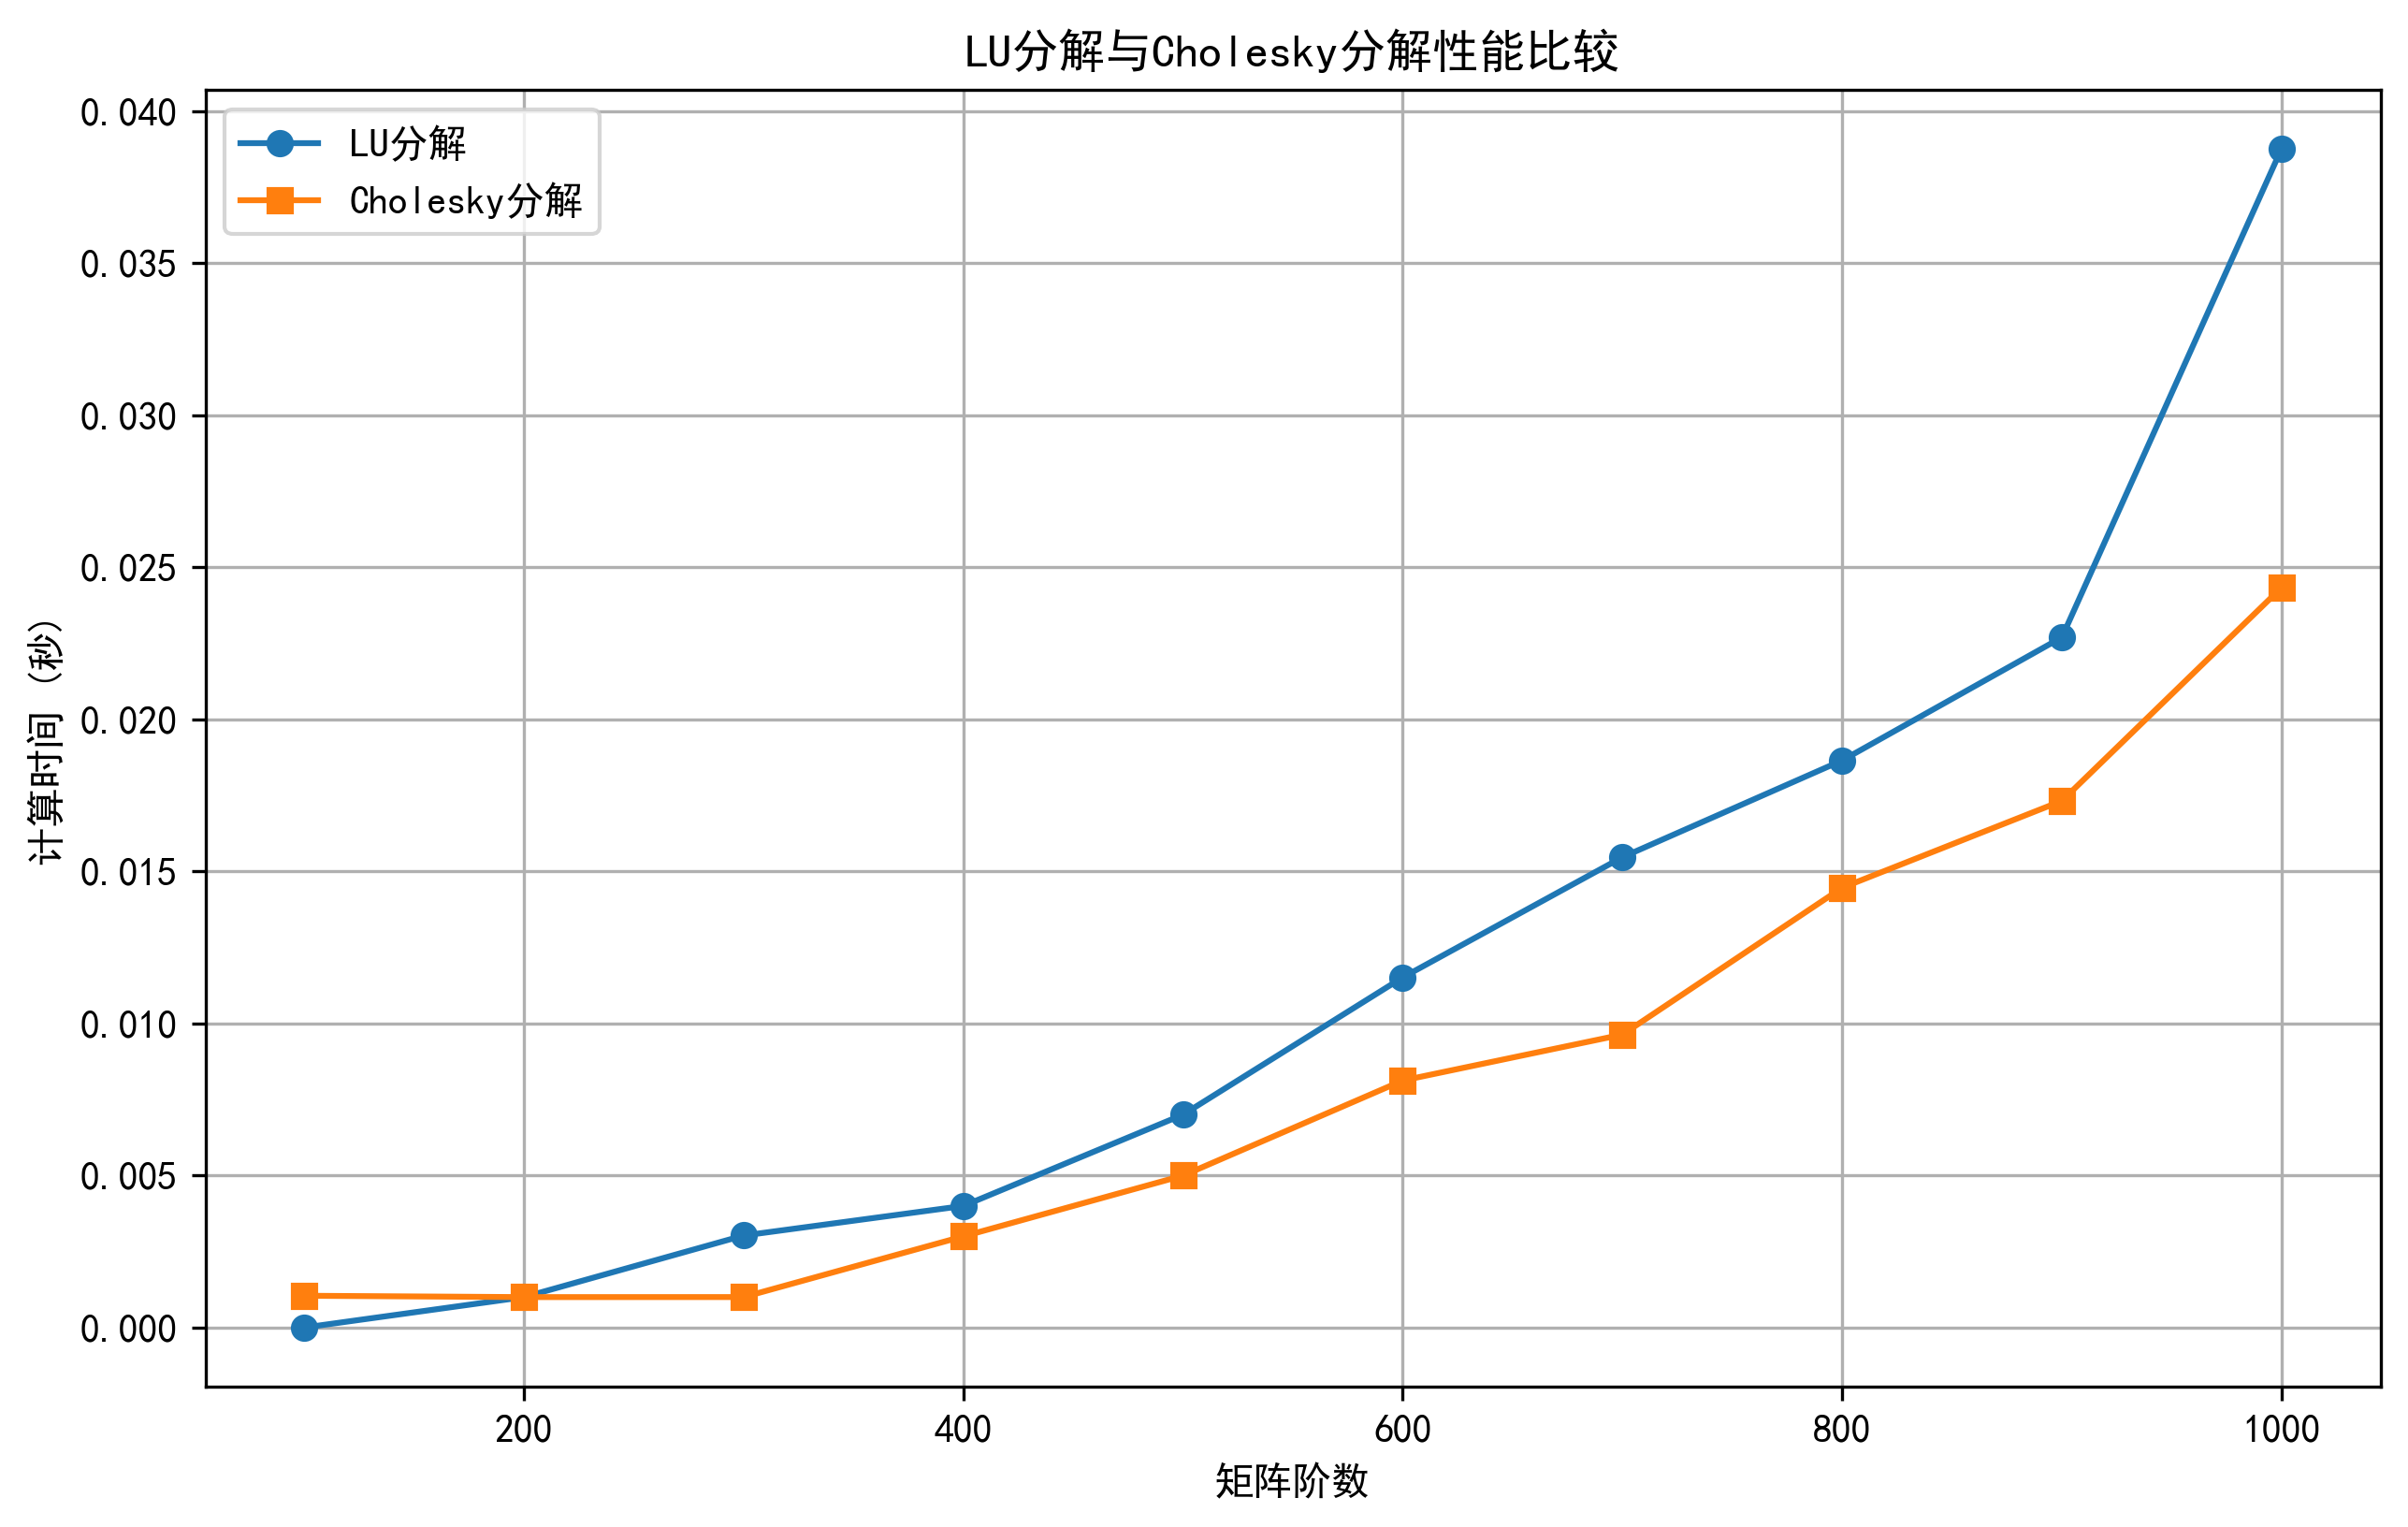

平均性能提升: 43.81%


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.sans-serif'] = ['SimHei']  # 图中显示中文
plt.rcParams['axes.unicode_minus'] = False  # 图中正常显示负号

def generate_spd_matrix(n):
    """生成对称正定矩阵"""
    A = np.random.randn(n, n)
    return A.T @ A + n * np.eye(n)  # 确保正定性

def lu_solve(A, b):

    start_time = time.time()
    P, L, U = scipy.linalg.lu(A)
    y = np.linalg.solve(L, P @ b)
    x = np.linalg.solve(U, y)
    return x, time.time() - start_time

def cholesky_solve(A, b):

    start_time = time.time()
    L = np.linalg.cholesky(A)
    y = np.linalg.solve(L, b)
    x = np.linalg.solve(L.T, y)
    return x, time.time() - start_time

def compare_methods():

    sizes = np.arange(100, 1100, 100)
    lu_times = []
    cholesky_times = []
    
    for n in sizes:

        A = generate_spd_matrix(n)
        b = np.random.rand(n)
        

        _, lu_time = lu_solve(A, b)
        lu_times.append(lu_time)
        

        _, cholesky_time = cholesky_solve(A, b)
        cholesky_times.append(cholesky_time)
    
    # 绘制比较结果
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, lu_times, 'o-', label='LU分解')
    plt.plot(sizes, cholesky_times, 's-', label='Cholesky分解')
    plt.xlabel('矩阵阶数')
    plt.ylabel('计算时间 (秒)')
    plt.title('LU分解与Cholesky分解性能比较')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 打印性能差异
    print(f"平均性能提升: {((np.mean(lu_times) / np.mean(cholesky_times)) - 1) * 100:.2f}%")

if __name__ == "__main__":
    import scipy.linalg
    compare_methods()